<h2 style="font-family: monospace; color: purple;"> Poker Player Patterns</h2>

The data needed is [here](https://www.kaggle.com/smeilz/poker-holdem-games#Export%20Holdem%20Manager%202.0%2012292016131233.txt), specific file used is 
<b><span style="color: black; background-color: red;">Export Holdem Manager 2.0 12302016144830.txt</span></b>.<br />
It represents a game of over 40 000 rounds played on a table with real money (prbbly in dolars).

<h3 style="color: green; font-family: monospace;">Environment settings</h3>

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

from lib import ActionId, TurnId

# rounds gathered (last one is not finished)
MAX_ROUND = 42688 - 1

nrounds, nrowdisplay = MAX_ROUND, 15
pd.options.display.max_rows = nrowdisplay

def setAxDefaults(ax, title, xlab, ylab):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

### Loading csv

In [2]:
load_path = Path.cwd() / 'tidy_data'

action_ids = pd.read_csv(load_path / 'action_ids.csv')
user_ids = pd.read_csv(load_path / 'user_ids.csv')
actions = pd.read_csv(load_path / 'actions.csv')
cardshow = pd.read_csv(load_path / 'cardshow.csv')
buyins = pd.read_csv(load_path / 'buyins.csv')
blinds = pd.read_csv(load_path / 'blinds.csv')

actions = actions[actions.round_id <= nrounds]
cardshow = cardshow[cardshow.round_id <= nrounds]
buyins = buyins[buyins.round_id <= nrounds]
blinds = blinds[blinds.round_id <= nrounds]

action_dict = dict(zip(action_ids.action_name, action_ids.action_id))
user_dict = list(user_ids.user.sort_values())

{'folds': 0, 'calls': 1, 'raises': 2, 'checks': 3, 'bets': 4, 'allin': 5}


### Basics
We'll gather some basic information about the players.
For each player we want:
- number of rounds played
- number of each action taken
- relative winnings

In [3]:
rounds_played = buyins.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        pd.DataFrame(
            data = {'rounds_played': [len(df.round_id)]}
        )
    )
).reset_index().drop(columns = ['level_1'])

In [4]:
n_actions = actions.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            key: [len(df.action_id[df.action_id == i])]
            for key, i in action_dict.items()
        }
    )
).reset_index().drop(columns = ['level_1'])
n_actions['all_actions'] = sum(
    getattr(n_actions, key) for key in action_dict
)

In [5]:
winnings = cardshow.groupby('user_id').apply(
    lambda df: pd.DataFrame(
        data = {
            'total_won': [df.amount.sum()],
            'avg_won': [df.amount.mean()]
        }
    )
).reset_index().drop(columns = ['level_1'])

Lets check the average winnings scatter plot.

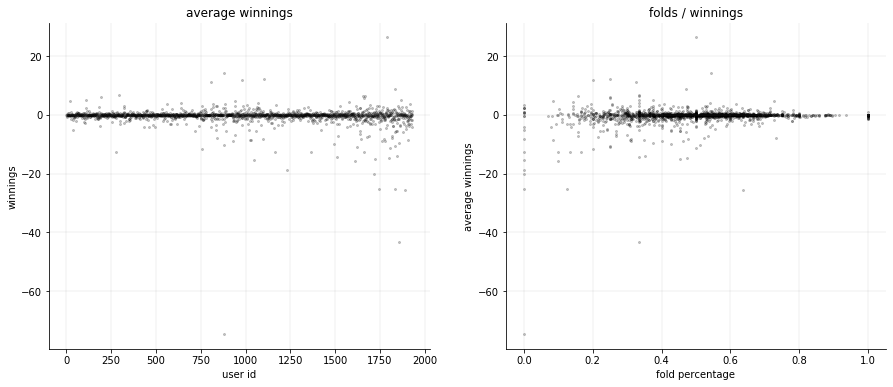

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
setAxDefaults(ax1, 'average winnings', 'user id', 'winnings')
setAxDefaults(ax2, 'folds / winnings', 'fold percentage', 'average winnings')

ax1.scatter(
    winnings.user_id,
    winnings.avg_won,
    s=4, c='black', alpha=0.2
);

ax2.scatter(
    n_actions.folds / n_actions.all_actions, 
    winnings.avg_won, s=4, c='black', alpha=0.2
);

We discovered here that being more conservative means losing less money.
This discovery has not yet been studied and is a massive achievement in this report.
I guess it makes sense.

Now our goal is to classify some players as conservative and some as agressive.
We'll construct a function which takes user's round actions and returns the level of agressiveness.

In [8]:
def levelOfAgressiveness(df):
    context_raise = 0
    for action in df.sort_values('action_order').iterrow():
        if actio.action_id == ActionId.RAISE:
            
        

(1933, 1933)

In [28]:
actions.sort_values('action_order')

,amount,round_id,turn,action_order,user_id,action_id
346487,0.0,36850.0,0.0,-1.0,1800,0
346485,0.0,12489.0,0.0,-1.0,679,0
346484,0.0,11803.0,0.0,-1.0,639,0
346486,0.0,18988.0,0.0,-1.0,1104,0
105852,0.0,7602.0,0.0,0.0,363,0
105847,0.0,7588.0,0.0,0.0,363,0
105835,0.0,7540.0,0.0,0.0,363,0
...,...,...,...,...,...,...
40448,0.0,2859.0,3.0,23.0,0,0
176743,0.0,25510.0,3.0,24.0,1410,0
